# **Comparison with other TCR clustering methods**
This notebook compares the clustering quality of *clusTCR* with existing TCR clustering methods and can be used to recreate the paper's figures. To use the notebook, clone *clusTCR*'s github repository ([https://github.com/svalkiers/clusTCR](https://github.com/svalkiers/clusTCR)) onto your device and pasting the path to the repo down here.

In [1]:
import os

# Path to clusTCR repo goes here:
os.chdir('/home/sebastiaan/PhD/Repositories/clusTCR/')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from clustcr.clustering.clustering import Clustering
from clustcr.input.datasets import vdjdb_cdr3_small, vdjdb_gliph2_small, vdjdb_epitopes_small, vdjdb_tcrdist_small
from clustcr.modules.gliph2.gliph2 import GLIPH2
from clustcr.modules.ismart.ismart import iSMART
from tcrdist.repertoire import TCRrep
from sklearn.cluster import DBSCAN

Set figure aesthetics.

In [3]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)

## **Calculate metrics**
**> Purity**  
Purity describes the fraction of sequences within a cluster targeting the same epitope.  
**> Purity_90**  
Fraction of clusters with purity > 90%.  
**> Retention**  
Retention is calculated as the number of sequences that end up in any cluster, relative to the total number of input sequences.  
**> Consistency**  
Consistency describes the fraction of sequences targeting the same epitope that are assigned to the same cluster.

In [15]:
results = []

# Different quality subsets of VDJdb
qscore = [0, 1, 2]
for q in qscore:
    
    # Data
    epitopes = vdj_epitopes_small(q = q)
    data_gliph2 = vdj_gliph2_small(q = q)
    data_cdr3 = vdj_cdr3_small(q = q)
    data_td = vdj_tcrdist_small(q = q)
    
    # GLIPH2
    GLIPH2(data_gliph2, os.path.abspath('../src/clusTCR/modules/gliph2/'))
    gliph2_output = pd.read_csv(path_in_data('methods/GLIPH2_{}.tsv'.format(len(data_gliph2))), sep='\t')
    gliph2_metrics = Metrics(gliph2_output, epitopes, name='GLIPH2')
    summ_gliph2 = gliph2_metrics.summary()
    
    # iSMART
    iSMART(data_cdr3, os.path.abspath('../src/clusTCR/modules/ismart/'))
    ismart_output = pd.read_csv(path_in_data('methods/iSMART_{}.tsv'.format(len(data_cdr3))), sep='\t')
    ismart_metrics = Metrics(ismart_output, epitopes, name='iSMART')
    summ_ismart = ismart_metrics.summary()
    
    # clusTCR
    twostep = Clustering(data_cdr3, method = 'two-step', n_cpus=8)
    ts_output = twostep.get_clusters()
    ts_metrics = Metrics(ts_output, epitopes, name='clusTCR')
    summ_ts = ts_metrics.summary()
    
    # tcrdist3
    if q != 0:
        print('pw dist calculations for {} sequences with tcrdist.'.format(len(data_td)))
        tr = TCRrep(cell_df = data_td,
                    organism = 'human',
                    chains = ['beta'],
                    db_file='alphabeta_gammadelta_db.tsv')
        d = tr.pw_cdr3_b_aa
        clustering = DBSCAN(eps=18, min_samples=2, n_jobs=-1).fit(d)
        labels = clustering.labels_
        data_td['cluster'] = labels
        data_td = data_td[data_td['cluster']!=-1]
        data_td.rename(columns={'cdr3_b_aa':'CDR3','v_b_gene':'V'}, inplace=True)
        td_metrics = Metrics(data_td, epitopes, name='tcrdist3')
        summ_td = td_metrics.summary()
    else:
        summ_td = pd.DataFrame({'actual':[None, None, None, None], 
                                'baseline':[None, None, None, None], 
                                'metrics':['retention', 'purity', 'purity_90', 'consistency'],
                                'method':['tcrdist3+DBSCAN']*4})
                               
    summ_total = pd.concat([summ_gliph2, summ_ismart, summ_ts, summ_td])
    summ_total['q'] = [q] * len(summ_total)
    results.append(summ_total)
                               
summary = pd.concat(results)
summary.to_csv('results/method_comparison_accuracy.tsv', sep = '\t', index = False)

Clustering 26679 sequences with GLIPH2.
Elapsed time: 53.947280406951904 seconds.
Saving output to: 
 --> /home/sebastiaan/PhD/Repositories/clusTCR/data/methods/GLIPH2_26679.tsv


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


Clustering 24981 sequences with iSMART.
Elapsed time: 27.477491855621338 seconds.
Saving output to: 
 --> /home/sebastiaan/PhD/Repositories/clusTCR/data/methods/iSMART_24981.tsv


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)
/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


Clustering 3403 sequences with GLIPH2.
Elapsed time: 5.1609227657318115 seconds.
Saving output to: 
 --> /home/sebastiaan/PhD/Repositories/clusTCR/data/methods/GLIPH2_3403.tsv


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


Clustering 2851 sequences with iSMART.
Elapsed time: 0.9944150447845459 seconds.
Saving output to: 
 --> /home/sebastiaan/PhD/Repositories/clusTCR/data/methods/iSMART_2851.tsv


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)
/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


pw dist calculations for 3403 sequences with tcrdist.


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


Clustering 594 sequences with GLIPH2.
Elapsed time: 2.613055944442749 seconds.
Saving output to: 
 --> /home/sebastiaan/PhD/Repositories/clusTCR/data/methods/GLIPH2_594.tsv


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


Clustering 495 sequences with iSMART.
Elapsed time: 0.28023242950439453 seconds.
Saving output to: 
 --> /home/sebastiaan/PhD/Repositories/clusTCR/data/methods/iSMART_495.tsv


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)
/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


pw dist calculations for 594 sequences with tcrdist.


/home/sebastiaan/PhD/Repositories/clusTCR/src/clusTCR/clusTCR.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.gt.drop_duplicates(inplace=True)


## **Plot results**

/home/sebastiaan/miniconda3/envs/tcr/lib/python3.6/site-packages/ipykernel_launcher.py:87: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


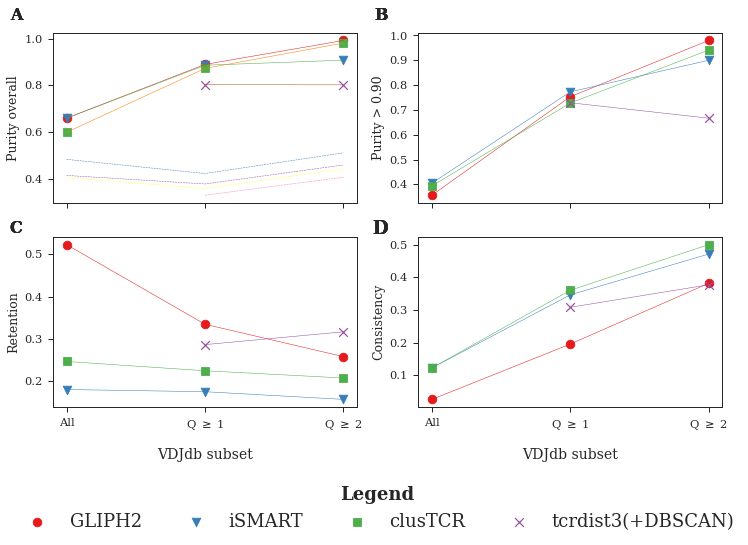

In [13]:
data = pd.read_csv('results/method_comparison_accuracy.tsv', sep = '\t')

# Generate figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8), sharex=True)

# Set x-axis labels
locs = [0, 1, 2]
labels = ['All', 'Q $\geq$ 1', 'Q $\geq$ 2']
plt.setp(((ax1, ax2), (ax3, ax4)), xticks=locs, xticklabels=labels)

# Different metrics
m1 = data[data['metrics']=='purity']
m2 = data[data['metrics']=='purity_90']
m3 = data[data['metrics']=='retention']
m4 = data[data['metrics']=='consistency']

# Different marker for each method
markers = ["o", "v", "s", "x"]

##########
# PURITY #
##########

for (marker,method) in zip(markers,m1.method.unique()):
    x = m1[m1['method']==method].q
    y = m1[m1['method']==method].actual
    ax1.scatter(x, y, marker=marker, s=75)
    ax1.set_ylabel('Purity overall')
    ax1.set_xlabel('')
#     ax1.tick_params(axis='y', which='major', labelsize=12)
#     ax1.tick_params(axis='x', which='major', labelsize=18)
    ax1.text(-0.1, 1.15, 'A', transform=ax1.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')

#############
# PURITY_90 #
#############

for (marker,method) in zip(markers,m1.method.unique()):
    x = m2[m2['method']==method].q
    y = m2[m2['method']==method].actual
    ax2.scatter(x, y, marker=marker,s=75)
    ax2.set_ylabel('Purity > 0.90')
    ax2.set_xlabel('')
#     ax2.tick_params(axis='y', which='major', labelsize=12)
#     ax2.tick_params(axis='x', which='major', labelsize=18)
    ax2.text(-0.1, 1.15, 'B', transform=ax2.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')

#############
# RETENTION #
#############
    
for (marker,method) in zip(markers,m1.method.unique()):
    x = m3[m3['method']==method].q
    y = m3[m3['method']==method].actual
    ax3.scatter(x, y, marker=marker, s=75)
    ax3.set_ylabel('Retention')
    ax3.set_xlabel('VDJdb subset', fontsize = 14, labelpad=16)
#     ax3.tick_params(axis='y', which='major', labelsize=12)
#     ax3.tick_params(axis='x', which='major', labelsize=18)
    ax3.text(-0.1, 1.10, 'C', transform=ax3.transAxes,fontsize=16, fontweight='bold', va='top', ha='right')

###############
# CONSISTENCY #
###############
    
for (marker,method) in zip(markers,m1.method.unique()):
    x = m4[m4['method']==method].q
    y = m4[m4['method']==method].actual
    ax4.scatter(x, y, marker=marker, s=75)
    ax4.set_ylabel('Consistency')
    ax4.set_xlabel('VDJdb subset', fontsize = 14, labelpad=16)
#     ax4.tick_params(axis='y', which='major', labelsize=12)
#     ax4.tick_params(axis='x', which='major', labelsize=18)
    ax4.text(-0.1, 1.10, 'D', transform=ax4.transAxes,fontsize=18, fontweight='bold', va='top', ha='right')

fig.subplots_adjust(bottom=0.23)

# Set figure legend
legend_labels = ['GLIPH2', 'iSMART', 'clusTCR', 'tcrdist3(+DBSCAN)']
legend = fig.legend([ax1, ax2, ax3, ax4],
                    labels=legend_labels,
                    loc="lower center",
                    borderaxespad=.1,
                    title="Legend",
                    fontsize="18",
                    ncol=4,
                    bbox_to_anchor=(.5, 0)
                   )
plt.setp(legend.get_title(),fontsize='18', fontweight='bold')

# Connect data points
for method in m1.method.unique():
    x = m1[m1['method']==method].q
    y_a = m1[m1['method']==method].actual
    y_b = m1[m1['method']==method].baseline
    ax1.plot(x, y_a, lw=.5)
    ax1.plot(x, y_b, lw=.5, linestyle='--')
for method in m1.method.unique():
    x = m2[m2['method']==method].q
    y = m2[m2['method']==method].actual
    ax2.plot(x, y, lw=.5)
for method in m1.method.unique():
    x = m3[m3['method']==method].q
    y = m3[m3['method']==method].actual
    ax3.plot(x, y, lw=.5)
for method in m1.method.unique():
    x = m4[m4['method']==method].q
    y = m4[m4['method']==method].actual
    ax4.plot(x, y, lw=.5)

# Save figure
# fig.savefig('results/figures/methods_comparison_accuracy.eps', format='eps', bbox_inches='tight')